In [1]:
import torch

import os
import numpy as np
import pandas as pd
#from tqdm import tqdm
#import seaborn as sns
#from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path_file = '/content/drive/My Drive/Colab Notebooks/csvData.csv'

Mounted at /content/drive


In [3]:
df = pd.read_csv(path_file)
print(df)

          date  confirmed  deaths  recovered
0    2020-1-22          0       0          0
1    2020-1-23          0       0          0
2    2020-1-24          0       0          0
3    2020-1-25          0       0          0
4    2020-1-26          0       0          0
..         ...        ...     ...        ...
217  2020-8-26    3310234   60472    2523771
218  2020-8-27    3387500   61529    2583948
219  2020-8-28    3463972   62550    2648998
220  2020-8-29    3542733   63498    2713933
221  2020-8-30    3621245   64469    2774801

[222 rows x 4 columns]


In [4]:
df.dtypes

date         object
confirmed     int64
deaths        int64
recovered     int64
dtype: object

In [ ]:
df.isnull().sum().sum()

0

In [5]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.index
print(df.dtypes)

confirmed    int64
deaths       int64
recovered    int64
dtype: object


In [6]:
print(df)

            confirmed  deaths  recovered
date                                    
2020-01-22          0       0          0
2020-01-23          0       0          0
2020-01-24          0       0          0
2020-01-25          0       0          0
2020-01-26          0       0          0
...               ...     ...        ...
2020-08-26    3310234   60472    2523771
2020-08-27    3387500   61529    2583948
2020-08-28    3463972   62550    2648998
2020-08-29    3542733   63498    2713933
2020-08-30    3621245   64469    2774801

[222 rows x 3 columns]


In [7]:
df1 = df[['confirmed']]
df1 = df1.diff()
df1.loc['2020-01-22', 'confirmed'] = 0.0
df1['confirmed'] = df1['confirmed'].astype(np.int64)
print(df1.head(15))
df1.dtypes

            confirmed
date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
2020-01-27          0
2020-01-28          0
2020-01-29          0
2020-01-30          1
2020-01-31          0
2020-02-01          0
2020-02-02          1
2020-02-03          1
2020-02-04          0
2020-02-05          0


confirmed    int64
dtype: object

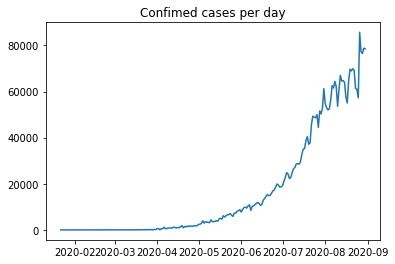

In [8]:
plt.plot(df1)
plt.title("Confimed cases per day");

In [9]:
df1.shape

(222, 1)

In [10]:
test_data_size = 44

train_data = df1[:-test_data_size]
test_data = df1[-test_data_size:]
train_data.shape

(178, 1)

In [11]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
#print(train_data)

In [12]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [13]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [14]:
train_data[:10]

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.83671848e-05],
       [0.00000000e+00]])

In [ ]:
#y_train[2:]
#X_train[2:]

In [16]:
#LSTM model class
class CoronaVirusPredictor(nn.Module):

  #constructor to declare layers and hyper parameters
  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
    input_size=n_features,
    hidden_size=n_hidden,
    num_layers=n_layers,
    dropout=0.5
    )   

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  #to reset the state of the stateless LSTM
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  #forward step and obtaining prediction
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [17]:
#function to train the model
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):
  pass